Попробуем улучшить точность модели распознавания вещей fashion_mnist используя сверточные нейронки, которые специально придуманыдля работы с изображениями
подготовку датасета возьмем из прошлого колаба а саму сеть - не выдумывая лишнего из официальной документации Keras

https://www.tensorflow.org/guide/keras/functional_api?hl=en#a_toy_resnet_model

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_classes = 10 # общее количество классов, в нашем случае это вещи в количестве 10 классов

learning_rate = 0.001 # скорость обучения нейронной сети - множитель оптимизатора
num_epochs = 15 # максимальное число эпох
batch_size = 128 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
                # это число стараются выбирать как степень двойки - чтобы была возможность проводить обучение на GPU

drop_rate = 0.5

In [ ]:
from keras.datasets import fashion_mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# разворачивать в вектор тензоры нет необходимости - сверточные слои принимают на вход напрямую матрицу из пикселей
# Нормализуем значения пикселей в диапазон 0-1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# преобразование к виду ванхот векторов для віходніх значений меток
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

С датасетом мы уже знакомы - нам нет нужды  еще раз его рассматривать через методы Numpy

поэтому переходим к модели сразу

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import losses
from keras import optimizers

# на входе у нас картинка 28*28 пикселов с каналом цветности - градации серого, то есть 1
inputs = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs) # глубина 32, фильтр 3*3
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)          # используем арихитектуру RESNET поэтому вычисляем обходной слой

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output) # и применяем его для перемножения тензоров в обходном слое
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)         # 256 нейрнов после разворачивания сверток
x = layers.Dropout(drop_rate)(x)                    # прореживание как регуляризация
outputs = layers.Dense(10, activation="softmax")(x) # выходной слой - классификатор 10 классов

model = keras.Model(inputs, outputs, name="train_resnet")
model.summary()

Model: "train_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['img[0][0]']                    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                       

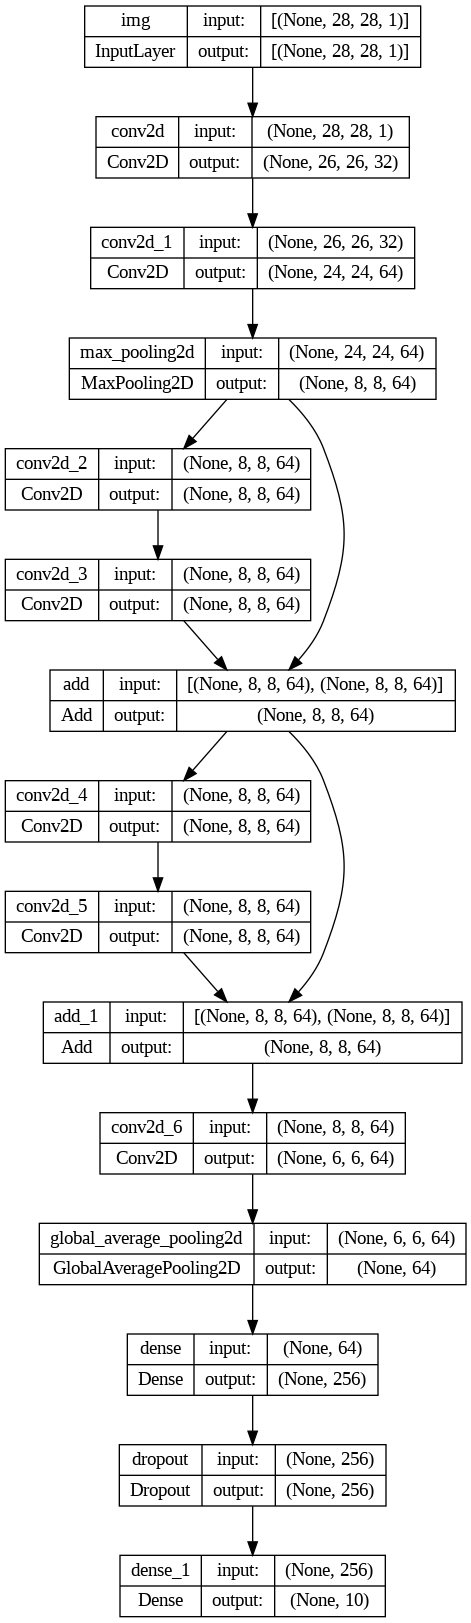

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [ ]:
model.compile(optimizer= optimizers.Adam(learning_rate=learning_rate),
              loss= losses.categorical_crossentropy,
              metrics='accuracy')

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    #callbacks=callbacks,
                    validation_split=0.2)

Epoch 1/15
375/375 [==============================] - 223s 588ms/step - loss: 0.9403 - accuracy: 0.6363 - val_loss: 0.6293 - val_accuracy: 0.7557
Epoch 2/15
375/375 [==============================] - 214s 571ms/step - loss: 0.5588 - accuracy: 0.7908 - val_loss: 0.4492 - val_accuracy: 0.8358
Epoch 3/15
375/375 [==============================] - 219s 584ms/step - loss: 0.4416 - accuracy: 0.8384 - val_loss: 0.4185 - val_accuracy: 0.8451
Epoch 4/15
375/375 [==============================] - 214s 570ms/step - loss: 0.3737 - accuracy: 0.8650 - val_loss: 0.3341 - val_accuracy: 0.8725
Epoch 5/15
375/375 [==============================] - 208s 554ms/step - loss: 0.3327 - accuracy: 0.8792 - val_loss: 0.3044 - val_accuracy: 0.8867
Epoch 6/15
375/375 [==============================] - 203s 541ms/step - loss: 0.3000 - accuracy: 0.8925 - val_loss: 0.2779 - val_accuracy: 0.8983
Epoch 7/15
375/375 [==============================] - 209s 557ms/step - loss: 0.2737 - accuracy: 0.9010 - val_loss: 0.2720 -

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 12s 38ms/step - loss: 0.2478 - accuracy: 0.9159


[0.24781034886837006, 0.9158999919891357]

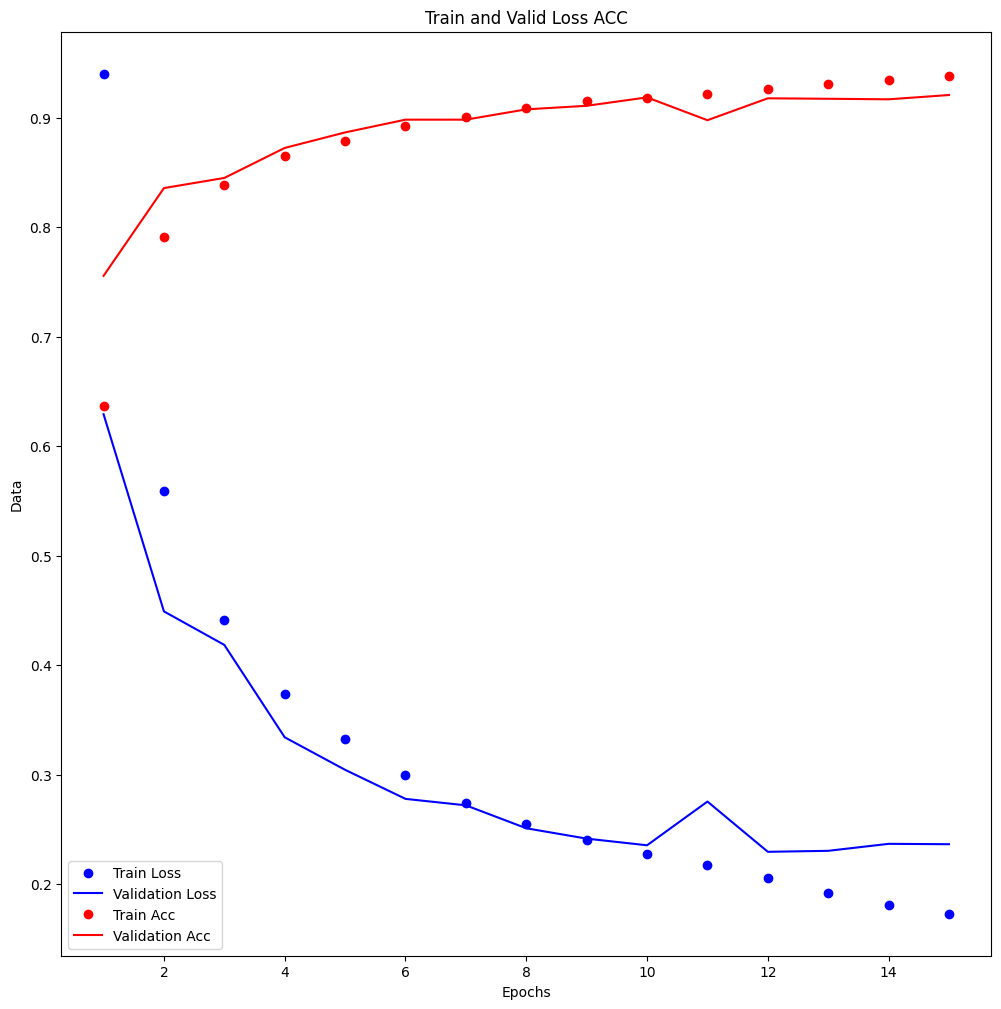

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epohs = range(1, num_epochs+1)

plt.figure(figsize=(12,12))
plt.plot(epohs, loss_values, 'bo', label= 'Train Loss')
plt.plot(epohs, val_loss_values, 'b', label= 'Validation Loss')
plt.plot(epohs, acc_values, 'ro', label= 'Train Acc')
plt.plot(epohs, val_acc_values, 'r', label= 'Validation Acc')
plt.title('Train and Valid Loss ACC')
plt.xlabel('Epochs')
plt.ylabel('Data')
plt.legend()

plt.show()

Как видим при применении RESNET архитектуры и интуитивно выбранных гиперпараметрах (с первого раза) точность распознавания составила уверенных 92 процента. И это мы еще не занимались подбором гиперпараметров. Если заняться этим вопросом, то думаю можно на 1-1,5 процента еще поднять точность построеной модели.


Теперь попробуем тоже самое с предобученной моделью на базе модели из Keras VGG16

In [12]:
# Загружаем датасет

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#vgg16_x_train = []
#for item in x_train:
#  new_item = np.zeros((32, 32), dtype=np.uint8)
#  new_item[0:28, 0:28] = item
#  vgg16_x_train.append(new_item)
#vgg16_x_train = np.array(vgg16_x_train)
#vgg16_x_train = np.repeat(vgg16_x_train, 3, axis=-1)
#print(vgg16_x_train.shape)

x_train = tf.image.resize(np.array(x_train)[..., tf.newaxis], (32, 32))
x_train = np.repeat(x_train, 3, axis=-1)
x_test = tf.image.resize(np.array(x_test)[..., tf.newaxis], (32, 32))
x_test = np.repeat(x_test, 3, axis=-1)
print(x_train.shape)

# разворачивать в вектор тензоры нет необходимости - сверточные слои принимают на вход напрямую матрицу из пикселей
# Нормализуем значения пикселей в диапазон 0-1
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

# преобразование к виду ванхот векторов для віходніх значений меток
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

(60000, 32, 32, 3)


In [13]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet",  # веса берем не рандомные, а уже предобученные
                  include_top=False,   # отключаем выходные 3 слоя - у нас будут свои
                  input_shape=(32, 32, 3) # запишем явно размерность по умолчанию
                  )
conv_base.trainable = False  # запрет на изменения весов предобученной модели

model = models.Sequential([
   conv_base,
   layers.Flatten(),   # после разворачивания полностью повторяем выходлные слои из прошлой модели - чтоб иметь возможность сравнить
   layers.Dense(256, activation="relu"),
   layers.Dropout(drop_rate),
   layers.Dense(10, activation="softmax"),
])

# метод compile полностью повторяем из предыдущей сети - чтобы была валидность сравнения моделей
model.compile(optimizer= optimizers.Adam(learning_rate=learning_rate),
              loss= losses.categorical_crossentropy,
              metrics='accuracy'
              )

# параметры для обучения - те же
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    #callbacks=callbacks,
                    validation_split=0.2)

Epoch 1/15
375/375 [==============================] - 665s 2s/step - loss: 0.7461 - accuracy: 0.7399 - val_loss: 0.5067 - val_accuracy: 0.8166
Epoch 2/15
375/375 [==============================] - 659s 2s/step - loss: 0.5069 - accuracy: 0.8191 - val_loss: 0.4496 - val_accuracy: 0.8361
Epoch 3/15
375/375 [==============================] - 659s 2s/step - loss: 0.4605 - accuracy: 0.8341 - val_loss: 0.4244 - val_accuracy: 0.8414
Epoch 4/15
375/375 [==============================] - 661s 2s/step - loss: 0.4334 - accuracy: 0.8430 - val_loss: 0.4034 - val_accuracy: 0.8498
Epoch 5/15
375/375 [==============================] - 656s 2s/step - loss: 0.4147 - accuracy: 0.8496 - val_loss: 0.3999 - val_accuracy: 0.8507
Epoch 6/15
375/375 [==============================] - 658s 2s/step - loss: 0.4018 - accuracy: 0.8537 - val_loss: 0.3882 - val_accuracy: 0.8547
Epoch 7/15
375/375 [==============================] - 656s 2s/step - loss: 0.3904 - accuracy: 0.8584 - val_loss: 0.3924 - val_accuracy: 0.8528

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 115s 366ms/step - loss: 0.3580 - accuracy: 0.8701


[0.3580320179462433, 0.8701000213623047]

Как видим - точность предобученной сети намного ниже чем сверточной. методы дообучения можно было бы попробовать но время обучения предобученной сети очень большое. Поэтому пропустим этот шаг и будем иметь ввиду, что VGG16&VGG19 лучше использовать для того - для чего ее и обучали - распознавание 1000 классов цветных картинок. Для чб маленьких картинок эта сеть явно избыточна.